In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import adjustText
import tensorflow_hub as hub
import seaborn as sns
from sklearn.utils import resample

In [3]:
df_data = pd.read_csv('../Data/data_1/clean_tripadvisor_6k.csv')
df_data

,text,label
0,anticipate husband stay TIME wedding anniversa...,negative
1,jury staff really friendly helpful room tiny d...,negative
2,disapointment excited stay hotel visit website...,negative
3,bother unfortunately botel move moor accessabl...,negative
4,average service ORG ORG ORG stay mean menigful...,negative
...,...,...
6813,great location stay grand plaza park hotel nig...,positive
6814,hide gem trendy seminyak stay lovely hotel nig...,positive
6815,couple good time read club med punta ORG revie...,positive
6816,exquisite elegance hotel prefection way stay t...,positive


In [4]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

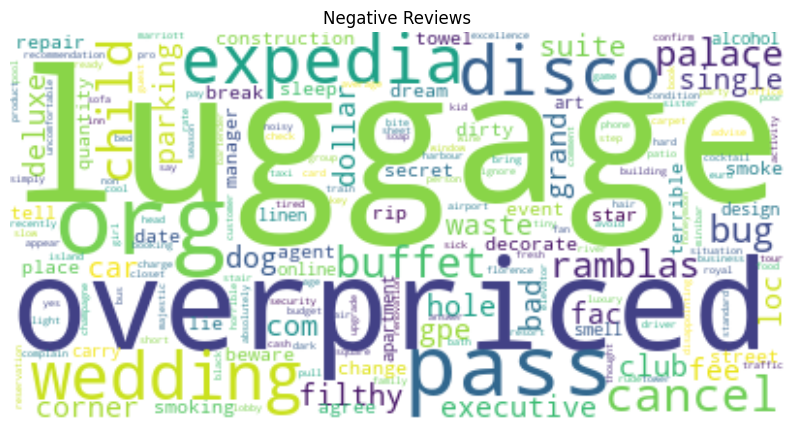

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


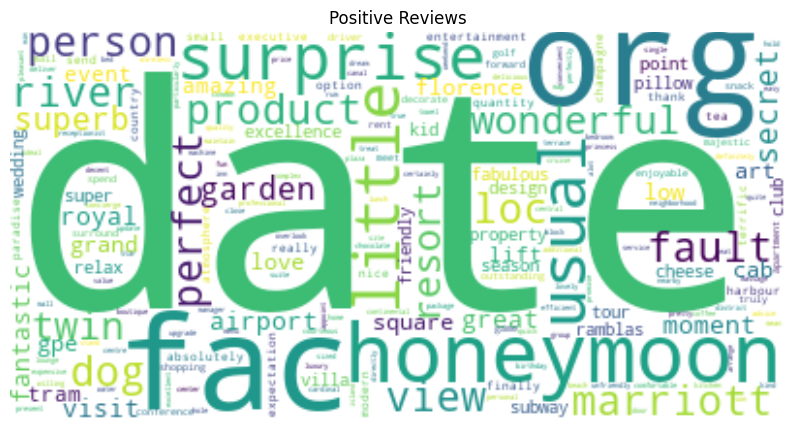

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


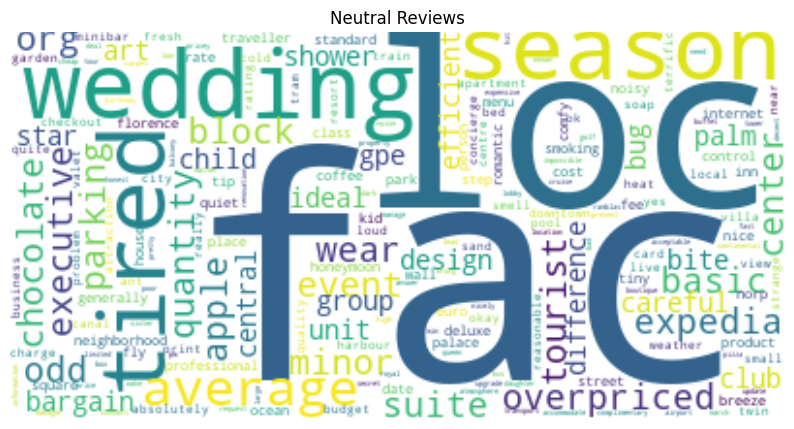

In [7]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [8]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [9]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,label
0,anticipate husband stay TIME wedding anniversa...,2
1,jury staff really friendly helpful room tiny d...,2
2,disapointment excited stay hotel visit website...,2
3,bother unfortunately botel move moor accessabl...,2
4,average service ORG ORG ORG stay mean menigful...,2
...,...,...
6813,great location stay grand plaza park hotel nig...,0
6814,hide gem trendy seminyak stay lovely hotel nig...,0
6815,couple good time read club med punta ORG revie...,0
6816,exquisite elegance hotel prefection way stay t...,0


In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5454,), (1364,), (5454,), (1364,))

In [22]:
EMBEDDING_DIM = 50
MAXLEN = 50
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 10000
NUM_LABELS = 3

In [23]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [24]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            500000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 128)          58880     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [26]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/10
171/171 [==============================] - 50s 130ms/step - loss: 0.9097 - accuracy: 0.5788 - val_loss: 0.7581 - val_accuracy: 0.6598
Epoch 2/10
171/171 [==============================] - 16s 91ms/step - loss: 0.6100 - accuracy: 0.7543 - val_loss: 0.7598 - val_accuracy: 0.6833
Epoch 3/10
171/171 [==============================] - 17s 98ms/step - loss: 0.4386 - accuracy: 0.8392 - val_loss: 0.8213 - val_accuracy: 0.6862
Epoch 4/10
171/171 [==============================] - 16s 96ms/step - loss: 0.2883 - accuracy: 0.9085 - val_loss: 0.9065 - val_accuracy: 0.6730
Epoch 5/10
171/171 [==============================] - 19s 113ms/step - loss: 0.2017 - accuracy: 0.9378 - val_loss: 1.0972 - val_accuracy: 0.6554
Epoch 6/10
171/171 [==============================] - 17s 101ms/step - loss: 0.1478 - accuracy: 0.9571 - val_loss: 1.2930 - val_accuracy: 0.6481
Epoch 7/10
171/171 [==============================] - 17s 98ms/step - loss: 0.1165 - accuracy: 0.9705 - val_loss: 1.5443 - val_accura

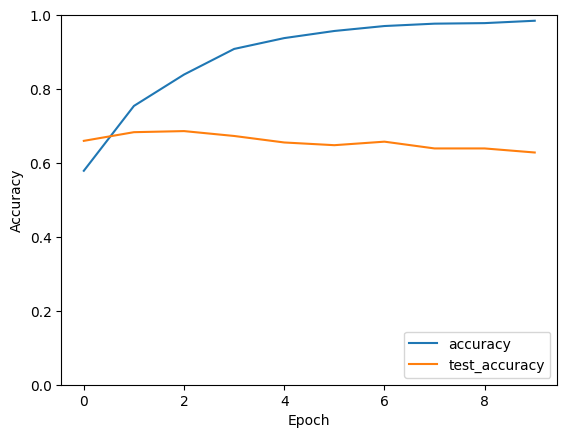

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [28]:
predictions = model.predict(x_test_pad)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test, predictions)

43/43 [==============================] - 7s 23ms/step


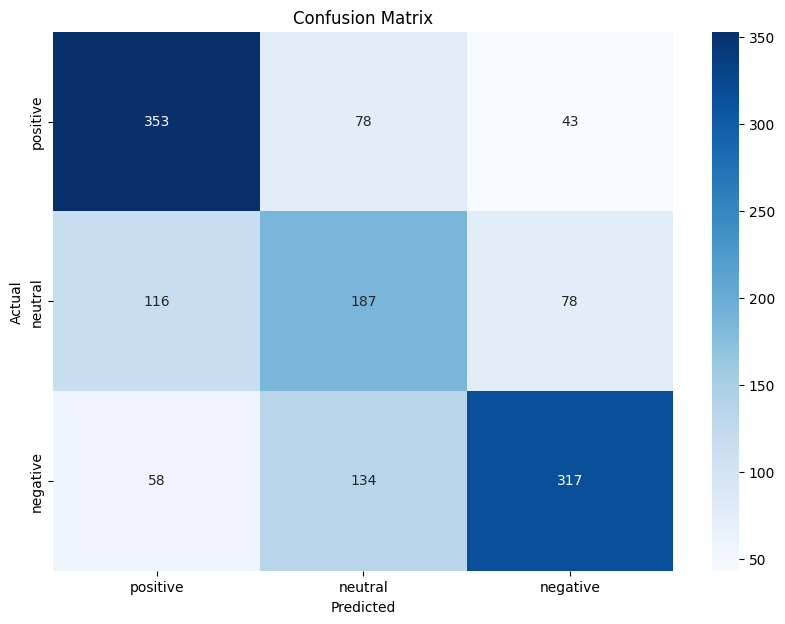

In [29]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()